# Análise de Cesta de Mercado

Fonte de Dados: <a href ="https://www.kaggle.com/competitions/instacart-market-basket-analysis/data">Instacart Market Basket Analysis<a>

O conjunto de cados contém uma amostra de mais de 3 milhões de pedidos de supermercado de mais de 200 mil usuários do Instacart. 

O objetivo do projeto é identificar a associação entre os produtos que as pessoas compram. 
    
Quem compra o produto A, também compra o produto B? Qual a força dessa relação?

## Carregando Pacotes

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import combinations
import efficient_apriori
from efficient_apriori import apriori

## Carregando Dados

In [2]:
# DataFrames
aisle = pd.read_csv('dados/aisles.csv')
department = pd.read_csv('dados/departments.csv')
order = pd.read_csv('dados/orders.csv')
product = pd.read_csv('dados/products.csv')
order_product_prior = pd.read_csv('dados/order_products__prior.csv')
order_product_train = pd.read_csv('dados/order_products__train.csv')

## Análise Exploratória

### Explorando Dados

In [3]:
count_array = np.array([['Aisles', aisle.shape[0], aisle.shape[1]],
                        ['Departament', department.shape[0], department.shape[1]],
                        ['Product', product.shape[0], product.shape[1]],
                        ['Order', order.shape[0], order.shape[1]],
                        ['Order_Product_Prior', order_product_prior.shape[0], order_product_prior.shape[1]],
                        ['Order_Product_Train', order_product_train.shape[0], order_product_train.shape[1]]])

pd.DataFrame(count_array, columns = ['DataFrame', 'Número de Registros', 'Número de Variáveis'])

,DataFrame,Número de Registros,Número de Variáveis
0,Aisles,134,2
1,Departament,21,2
2,Product,49688,4
3,Order,3421083,7
4,Order_Product_Prior,32434489,4
5,Order_Product_Train,1384617,4


In [4]:
aisle.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
department.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
order_product_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
# Total de registros por categoria de eval_set
order['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

### Merge das Tabelas 


In [11]:
# Merge order_product_prior with order, product, aisle and department
order_product_prior = order_product_prior.merge(order, on = 'order_id', how = 'left')
order_product_prior = order_product_prior.merge(product, on = 'product_id', how = 'left')
order_product_prior = order_product_prior.merge(department, on = 'department_id', how = 'left')
order_product_prior = order_product_prior.merge(aisle, on = 'aisle_id', how = 'left')

order_product_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,pantry,baking ingredients
5,2,17794,6,1,202279,prior,3,5,9,8.0,Carrots,83,4,produce,fresh vegetables
6,2,40141,7,1,202279,prior,3,5,9,8.0,Original Unflavored Gelatine Mix,105,13,pantry,doughs gelatins bake mixes
7,2,1819,8,1,202279,prior,3,5,9,8.0,All Natural No Stir Creamy Almond Butter,88,13,pantry,spreads
8,2,43668,9,0,202279,prior,3,5,9,8.0,Classic Blend Cole Slaw,123,4,produce,packaged vegetables fruits
9,3,33754,1,1,205970,prior,16,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16,dairy eggs,yogurt


In [12]:
# Merge order_product_train with order, product, aisle and department
order_product_train = order_product_train.merge(order, on = 'order_id', how = 'left')
order_product_train = order_product_train.merge(product, on = 'product_id', how = 'left')
order_product_train = order_product_train.merge(department, on = 'department_id', how = 'left')
order_product_train = order_product_train.merge(aisle, on = 'aisle_id', how = 'left')

order_product_train.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,produce,fresh vegetables
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,produce,fresh vegetables
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood
5,1,13176,6,0,112108,train,4,4,10,9.0,Bag of Organic Bananas,24,4,produce,fresh fruits
6,1,47209,7,0,112108,train,4,4,10,9.0,Organic Hass Avocado,24,4,produce,fresh fruits
7,1,22035,8,1,112108,train,4,4,10,9.0,Organic Whole String Cheese,21,16,dairy eggs,packaged cheese
8,36,39612,1,0,79431,train,23,6,18,30.0,Grated Pecorino Romano Cheese,2,16,dairy eggs,specialty cheeses
9,36,19660,2,1,79431,train,23,6,18,30.0,Spring Water,115,7,beverages,water seltzer sparkling water


### Análise de Valores Ausentes

In [13]:
order_product_prior.isnull().sum() / len(order_product_prior) * 100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
department                0.00000
aisle                     0.00000
dtype: float64

In [14]:
order_product_train.isna().sum() / len(order_product_train) * 100

order_id                  0.0
product_id                0.0
add_to_cart_order         0.0
reordered                 0.0
user_id                   0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
product_name              0.0
aisle_id                  0.0
department_id             0.0
department                0.0
aisle                     0.0
dtype: float64

A variável days_since_prior_order possui 6.4% de valores ausentes, estes dados serão mantidos por ser um percentual baixo e ser uma variável que não irá influenciar no algoritmo MBA.

### Agrupando dados de 'product_id' por 'order_id'

In [15]:
%%time
order_grouped = pd.DataFrame(order_product_prior.groupby('order_id')['product_id'])
prod_ = []
for i in range(len(order_grouped[0])):
  prod_.append(list(order_grouped.iloc[i][1]))
order_ = order_grouped[0]
transactions = pd.DataFrame({'OrderID' : order_, 'Products' : prod_})
transactions.head(10)

Wall time: 11min 47s


,OrderID,Products
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


### 1- Qual o Número de Pedidos Mais Frequente Entre os Usuários?

In [16]:
# Number of orders per user
number_orders_per_user = order.groupby("user_id")['order_number'].aggregate(np.max).reset_index()
number_orders_per_user.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [17]:
# Count by number of orders
count_per_number_orders = number_orders_per_user.order_number.value_counts()
count_per_number_orders.head()

4    23986
5    19590
6    16165
7    13850
8    11700
Name: order_number, dtype: int64

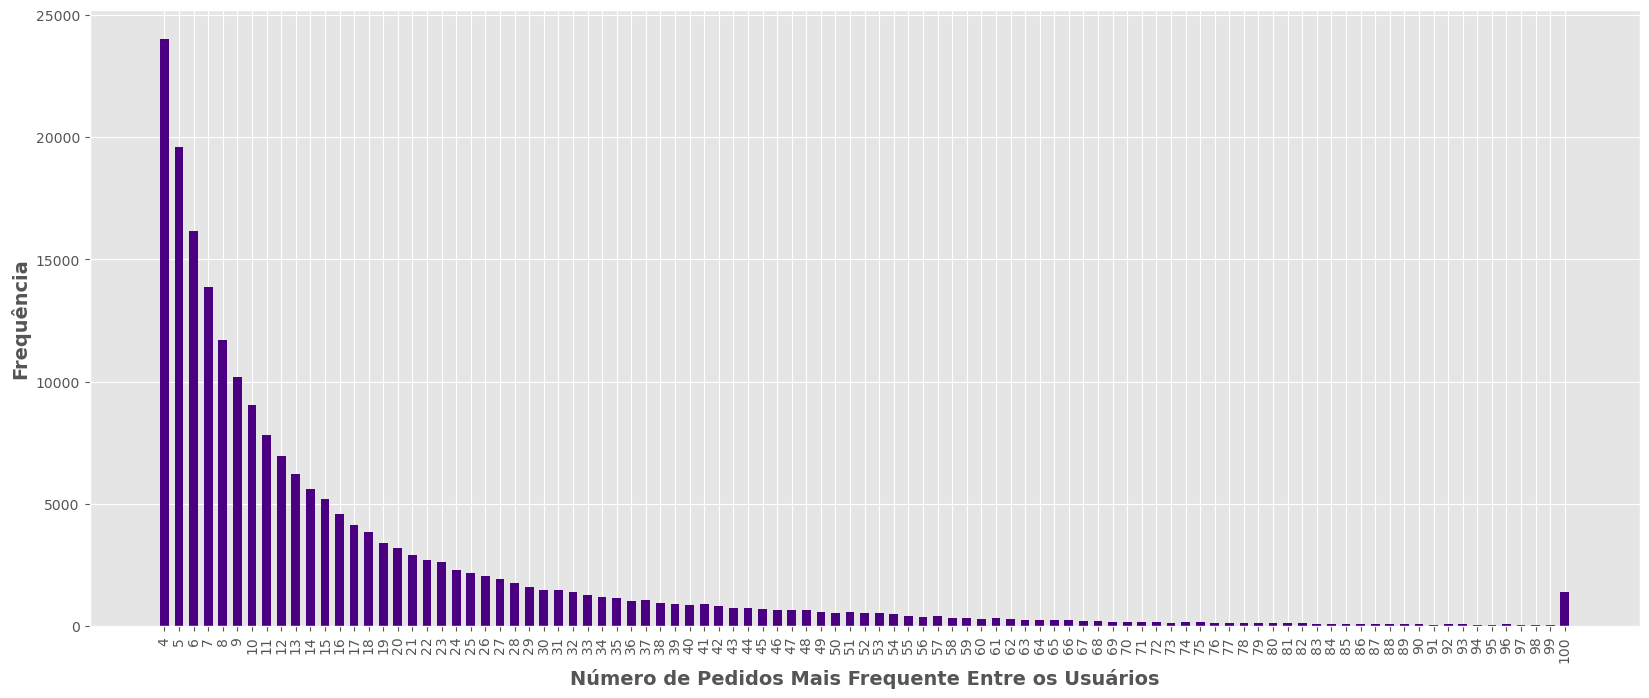

In [18]:
# Plot
plt.style.use('ggplot')
plt.figure(figsize = (20,8))
plt.bar(count_per_number_orders.index, count_per_number_orders.values, color = 'indigo', width = 0.6)
plt.xticks(count_per_number_orders.index, rotation = 'vertical')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xlabel('Número de Pedidos Mais Frequente Entre os Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

### 2 - Qual dia da semana tem o maior número de pedidos?

In [19]:
# Count the numer of order lines where the day of the week equal a (0 = domingo, 1 = segunda, ...)
x = [0, 1, 2, 3, 4, 5, 6]
y = [order[order['order_dow'] == 0].shape[0],
     order[order['order_dow'] == 1].shape[0],
     order[order['order_dow'] == 2].shape[0],
     order[order['order_dow']==3].shape[0],
     order[order['order_dow']==4].shape[0],
     order[order['order_dow']==5].shape[0],
     order[order['order_dow']==6].shape[0]]

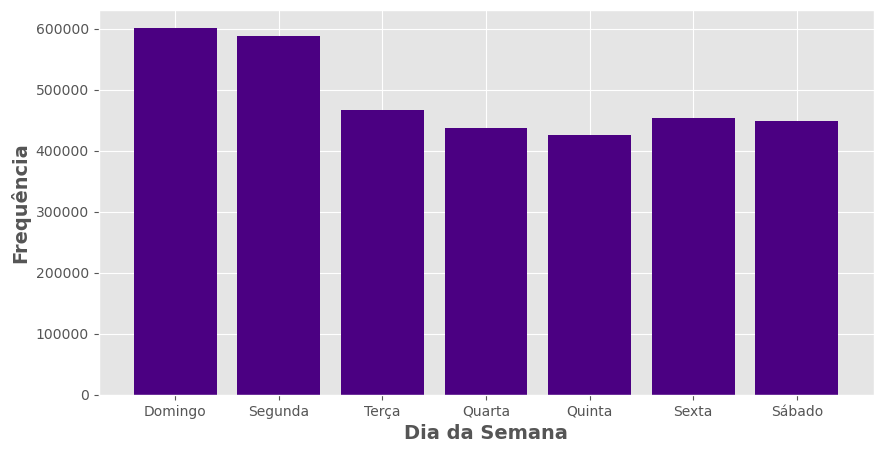

In [20]:
# Plot
plt.figure(figsize = (10,5))
plt.bar(x, y, color = 'indigo')
plt.xlabel('Dia da Semana', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xticks(x, ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], rotation = 0)
plt.show()

### 3 - Qual a hora do dia possui o maior número de pedidos?

In [21]:
count_order_per_hours = order.order_hour_of_day.value_counts().sort_index()
count_order_per_hours.head()

0    22758
1    12398
2     7539
3     5474
4     5527
Name: order_hour_of_day, dtype: int64

In [22]:
type(count_order_per_hours)

pandas.core.series.Series

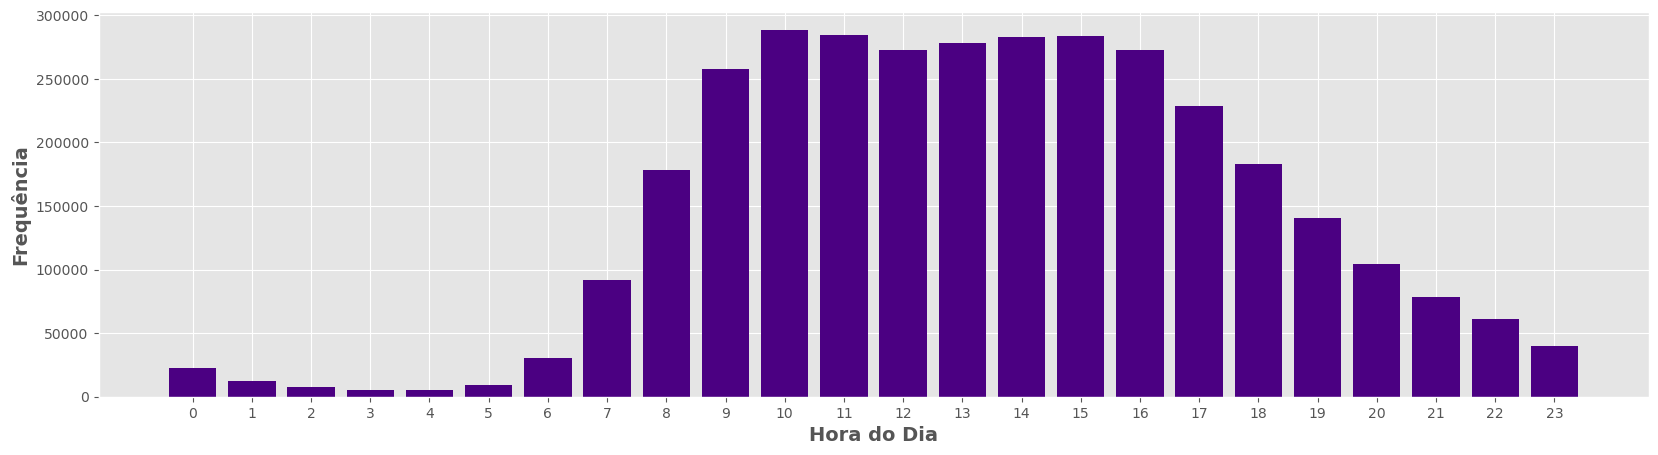

In [23]:
plt.figure(figsize = (20,5))
plt.bar(count_order_per_hours.index, count_order_per_hours.values, color = 'indigo')
plt.xlabel('Hora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xticks(count_order_per_hours.index)
plt.show()

### 4 - Qual Departamento tem o maior número de pedidos?

In [24]:
orders_by_departmant = order_product_prior['department'].value_counts()
type(orders_by_departmant)

pandas.core.series.Series

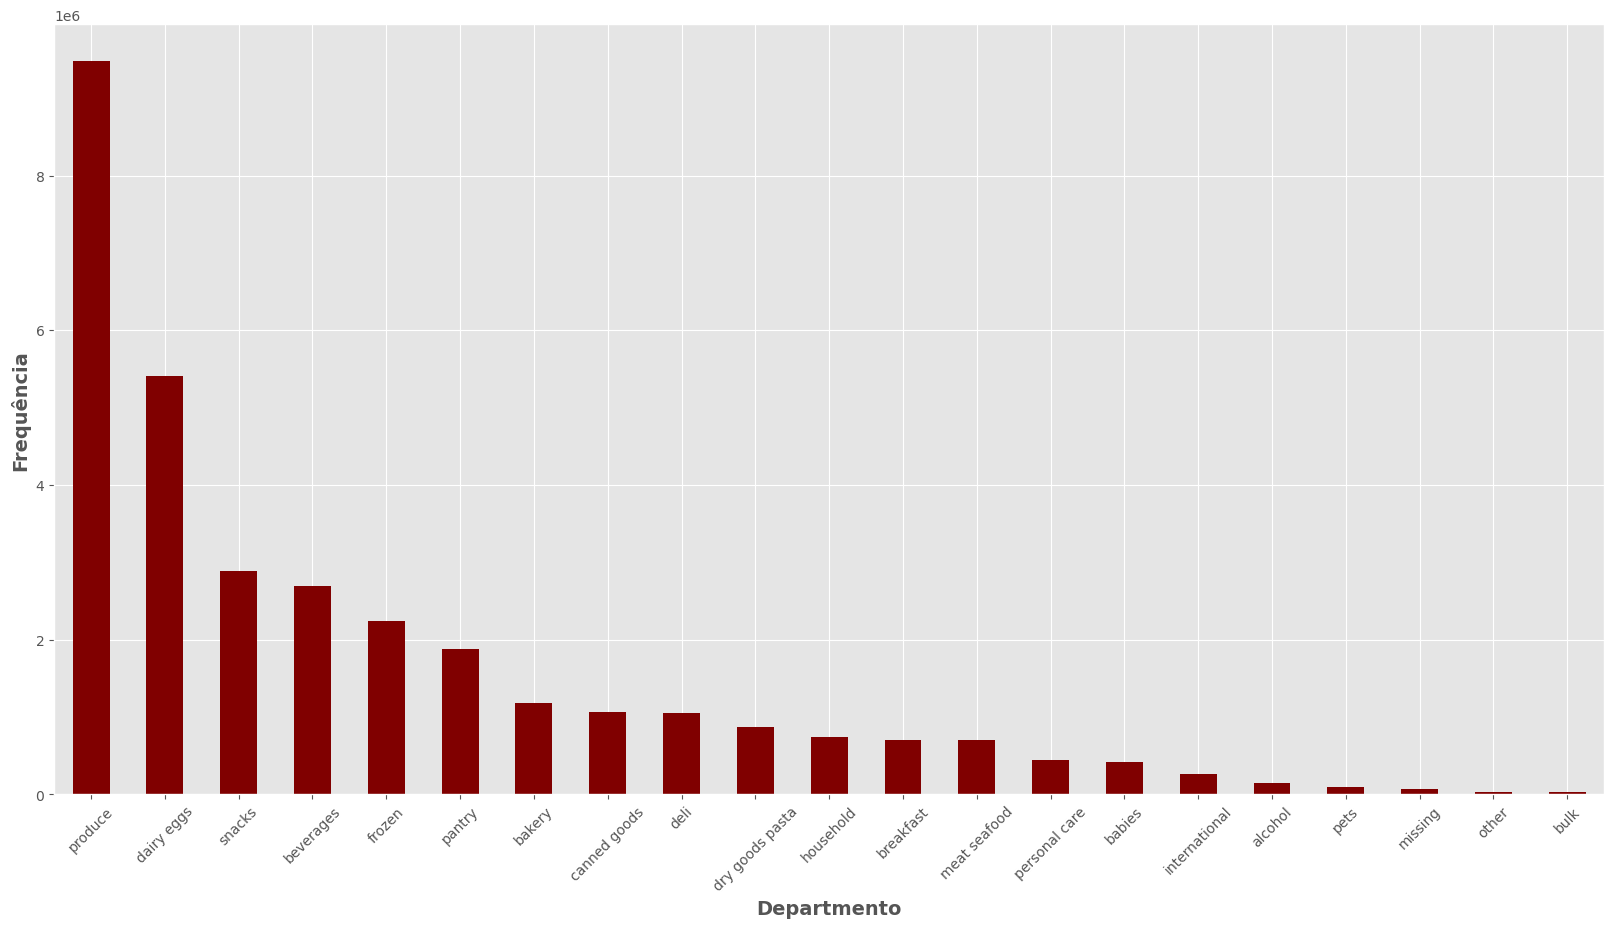

In [25]:
# Plot
plt.figure(figsize = (20,10))
orders_by_departmant.plot(kind = 'bar', color = 'maroon')
plt.xticks(rotation = 45)
plt.xlabel('Departmento', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 5- Quais os 10 Principais Corredores Por Frequência de Pedidos?

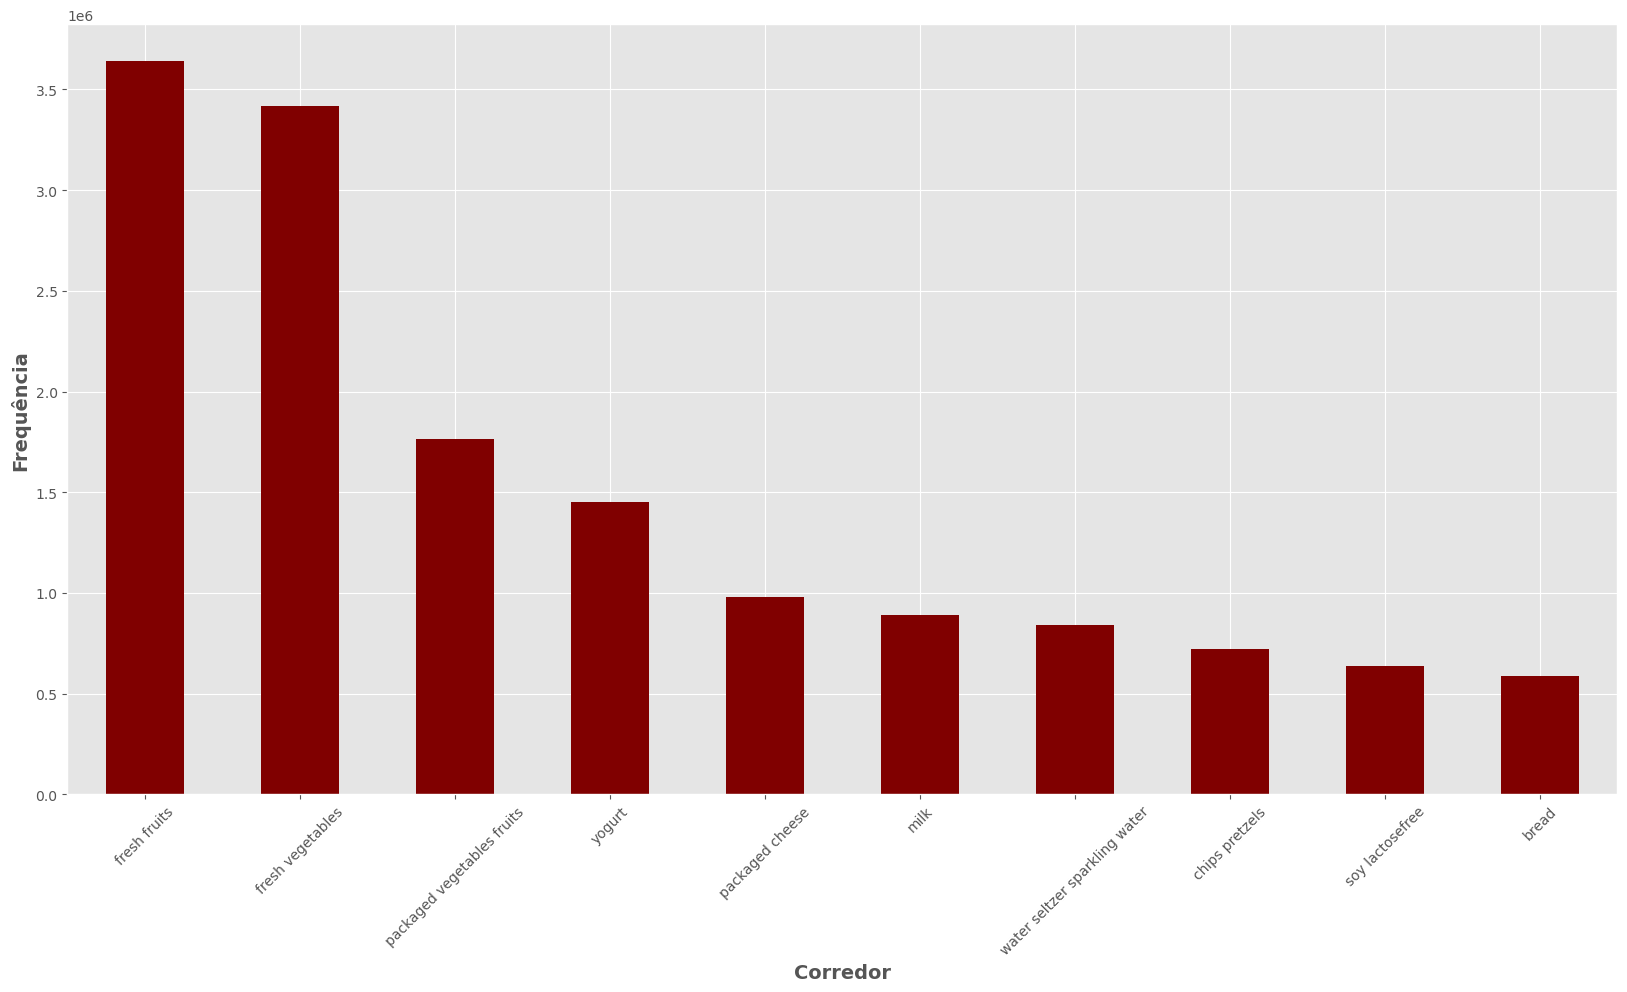

In [26]:
orders_by_aisle = order_product_prior.aisle.value_counts()
plt.figure(figsize = (20,10))
orders_by_aisle[0:10].plot(kind = 'bar', color = 'maroon')
plt.xticks(rotation = 45)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 6- Quais os 20 Principais Produtos Por Frequência de Pedidos?

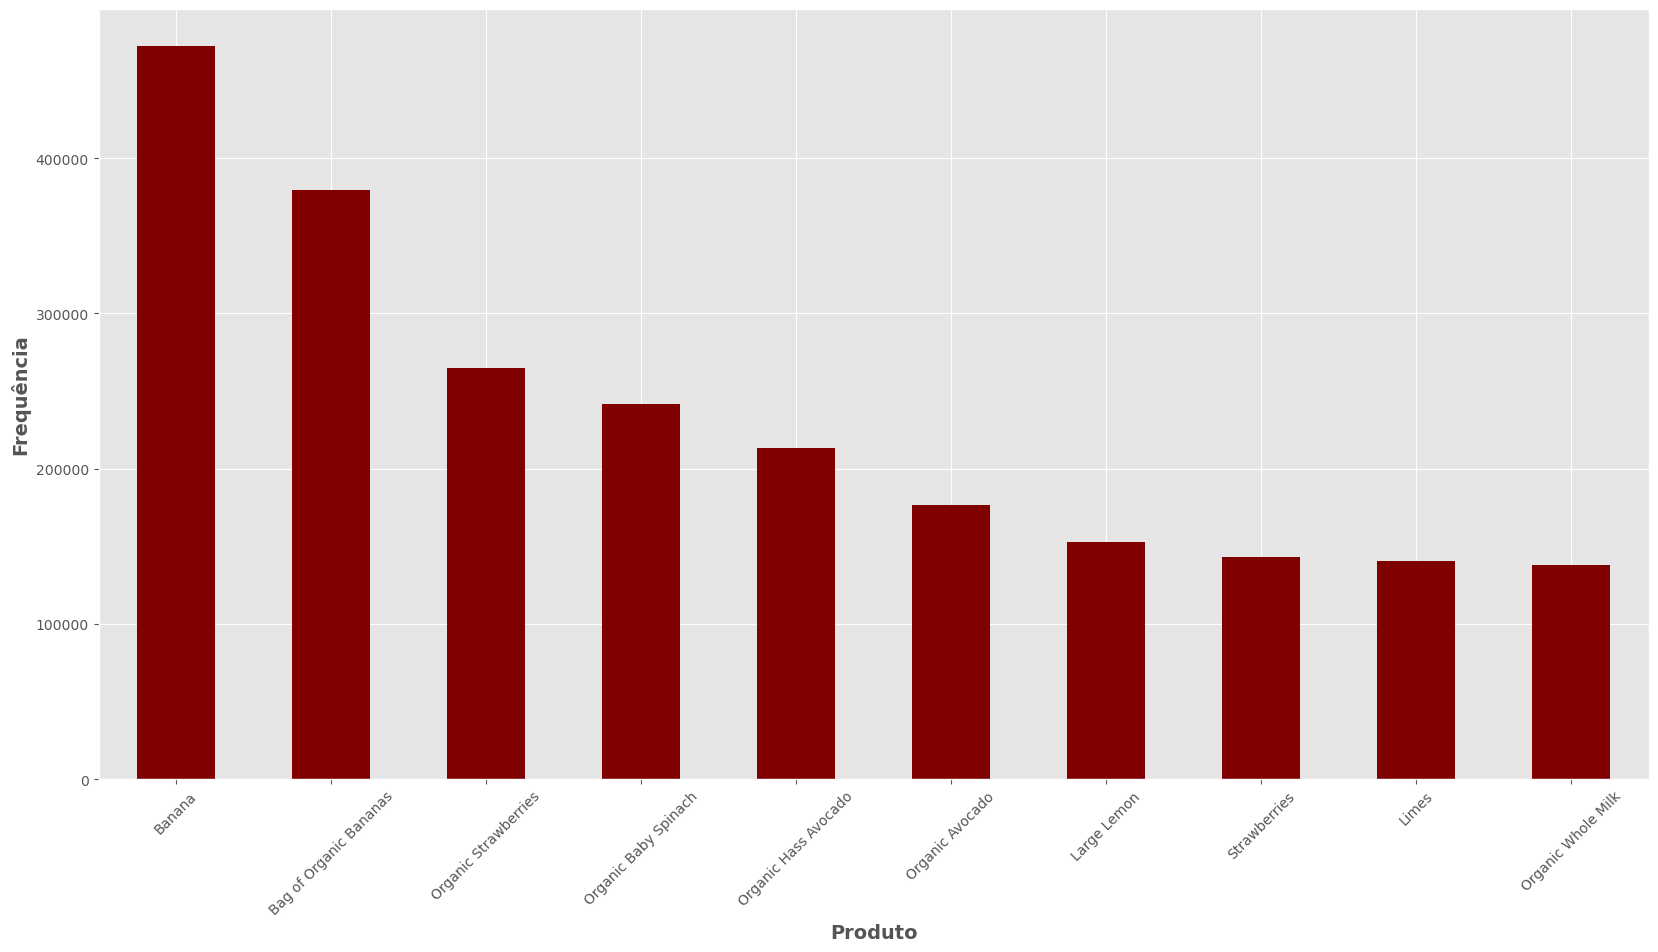

In [27]:
orders_by_product = order_product_prior.product_name.value_counts()
plt.figure(figsize = (20,10))
orders_by_product[0:10].plot(kind = 'bar', color = 'maroon')
plt.xticks(rotation = 45)
plt.xlabel('Produto', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 7- Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (reorder)

In [28]:
temp_df = order_product_prior.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count': 'total', 'sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

In [29]:
labels = list(temp_df.product_name[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])  

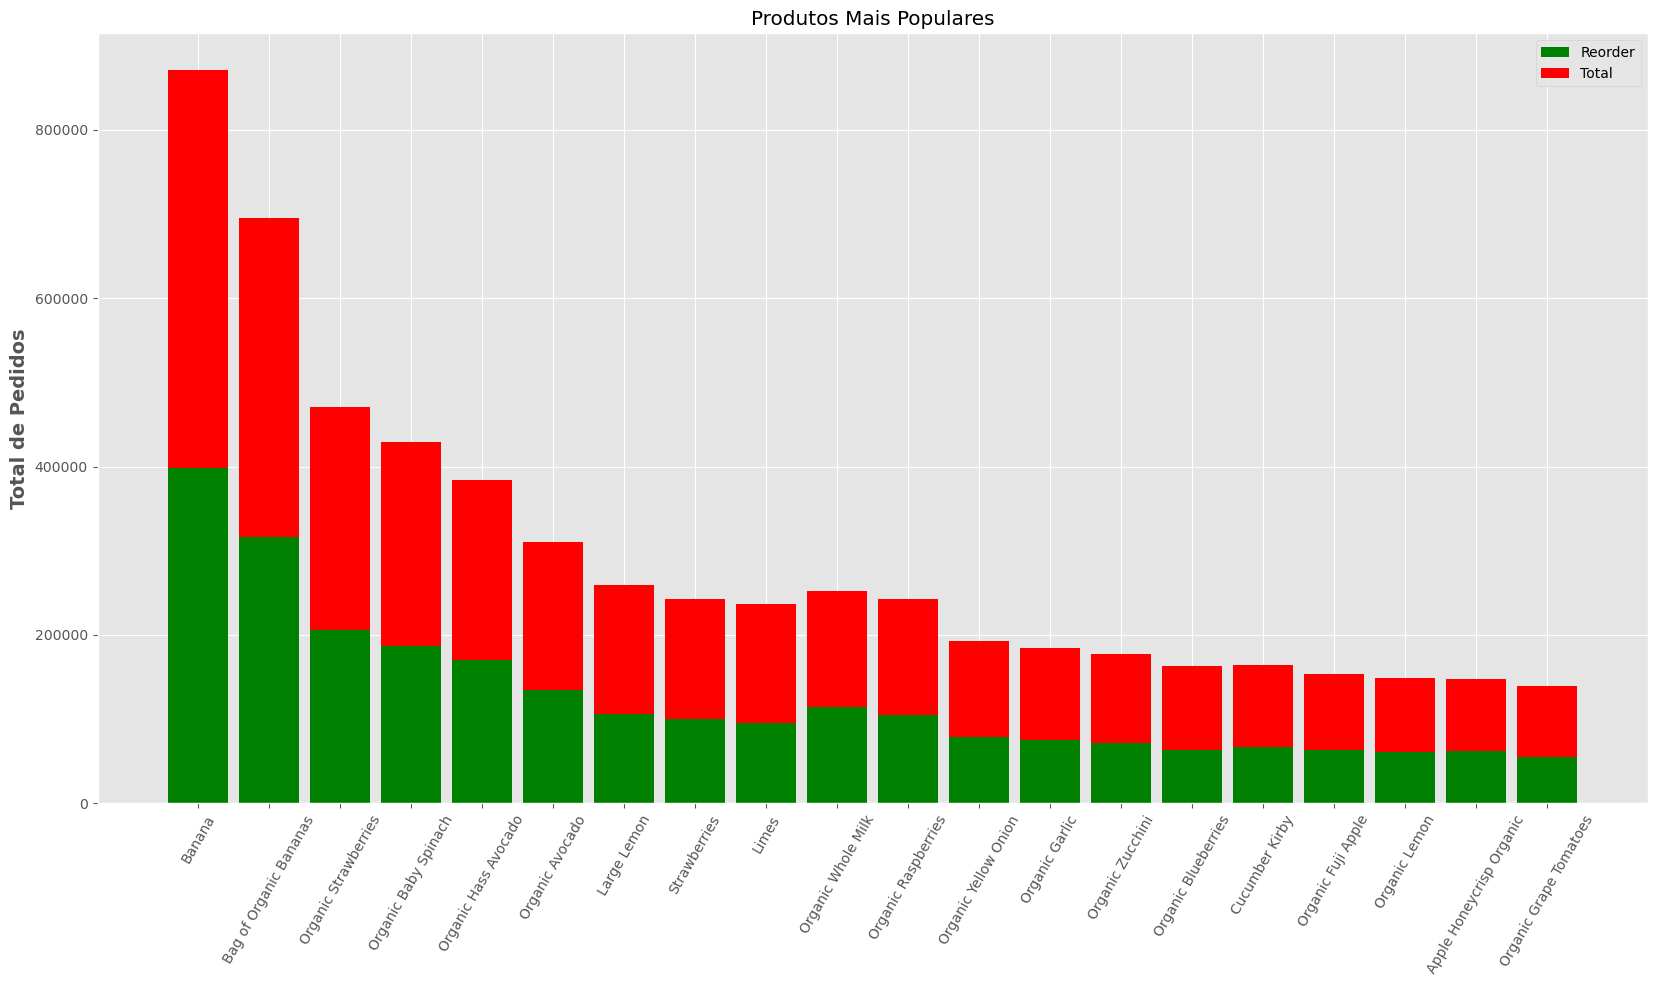

In [36]:
width = 0.85
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title('Produtos Mais Populares')
plt.xticks(rotation = 60)
plt.show()

### 8- Análise de Taxa Reorder Por Departamento 

In [38]:
temp_df = order_product_prior.groupby("department")["reordered"].aggregate('mean').reset_index()
temp_df.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


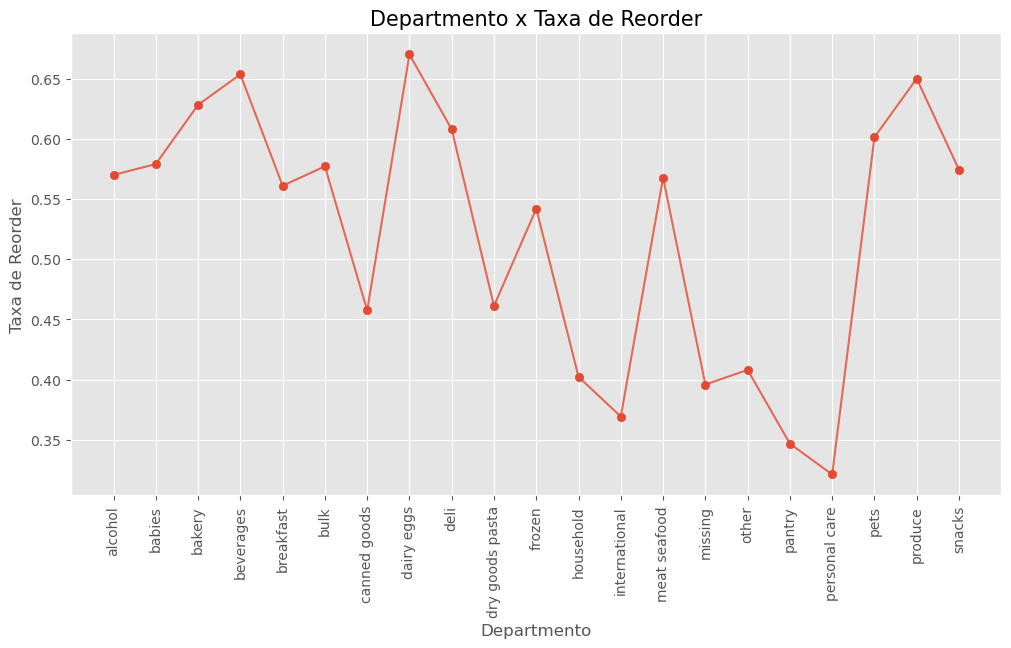

In [44]:
plt.figure(figsize = (12,6))
plt.plot(list(temp_df['department']), temp_df['reordered'].values, alpha = 0.8)
plt.scatter(list(temp_df['department']), temp_df['reordered'].values)
plt.ylabel('Taxa de Reorder', fontsize = 12)
plt.xlabel('Departmento', fontsize = 12)
plt.title("Departmento x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

### 9 - Total de Reorder e Pedidos por Departamento

In [46]:
temp_df = order_product_prior.groupby('department')['reordered'].agg(['count', 'sum']).rename(columns = {'count': 'total', 'sum': 'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()
temp_df.head()

,department,total,reorders
0,produce,9479291,6160710
1,dairy eggs,5414016,3627221
2,snacks,2887550,1657973
3,beverages,2690129,1757892
4,frozen,2236432,1211890


In [48]:
labels = list(temp_df.department[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])  

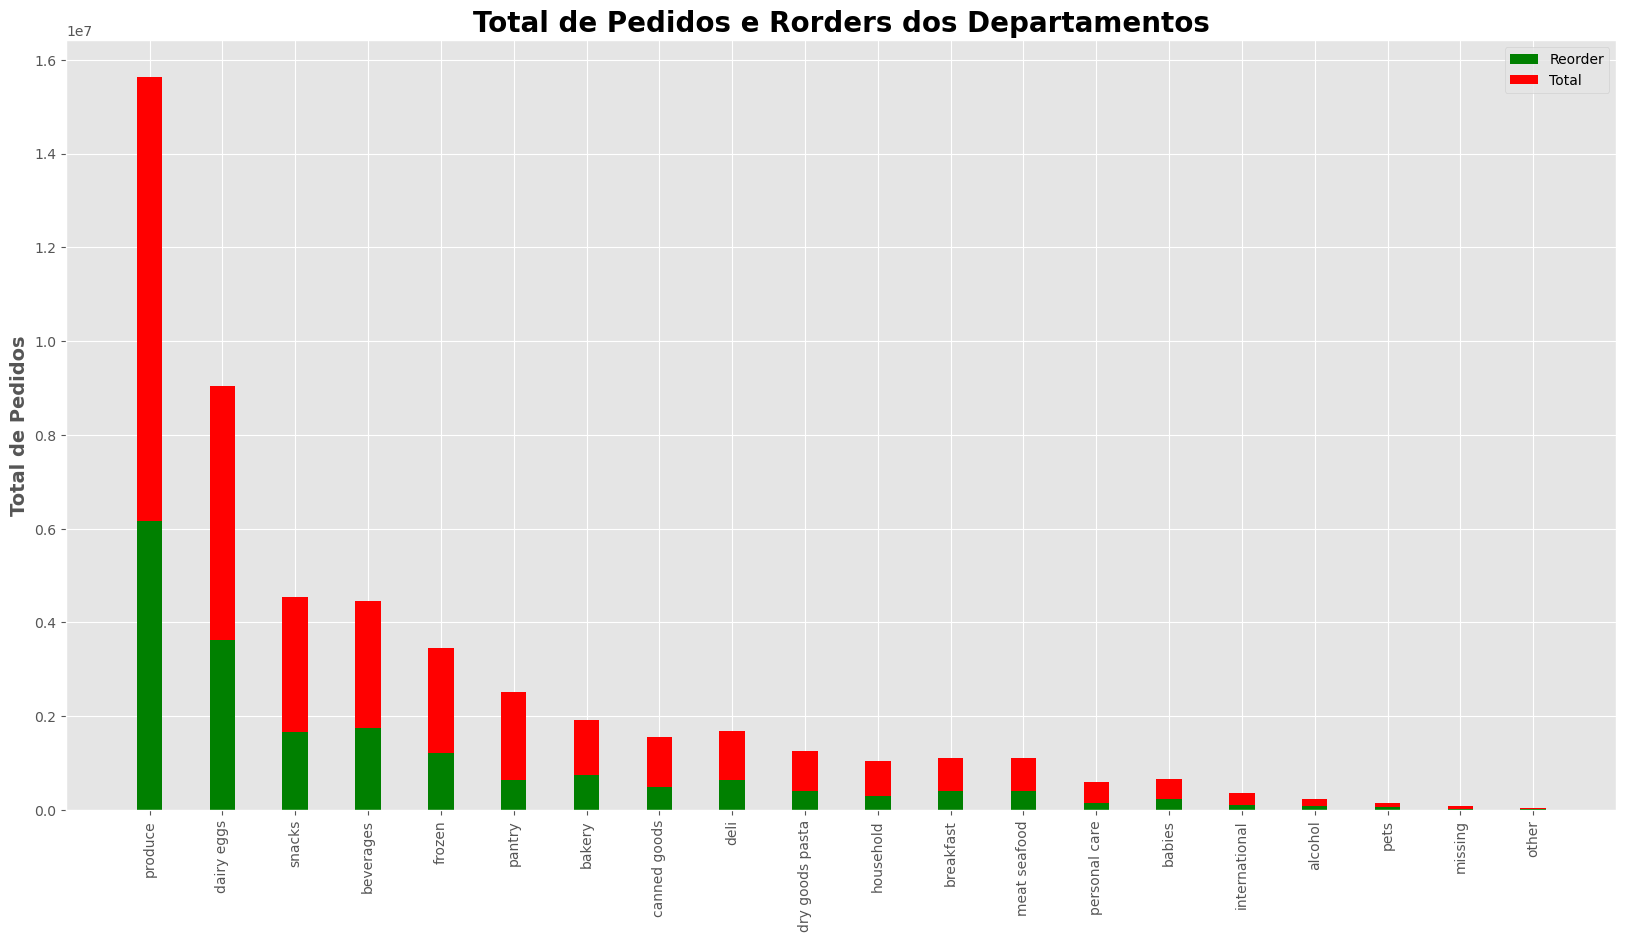

In [51]:
width = 0.35 
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Rorders dos Departamentos", fontsize = 20, fontweight = 'bold')
plt.xticks(rotation = 90)
plt.show()

### 10 - Reorder por Corredor

In [55]:
temp_df = order_product_prior.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
# temp_df = temp_df.sort_values(by = 'reordered', ascending = False)
temp_df.head()

,aisle,reordered
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980
3,baby bath body care,0.295770
4,baby food formula,0.590259


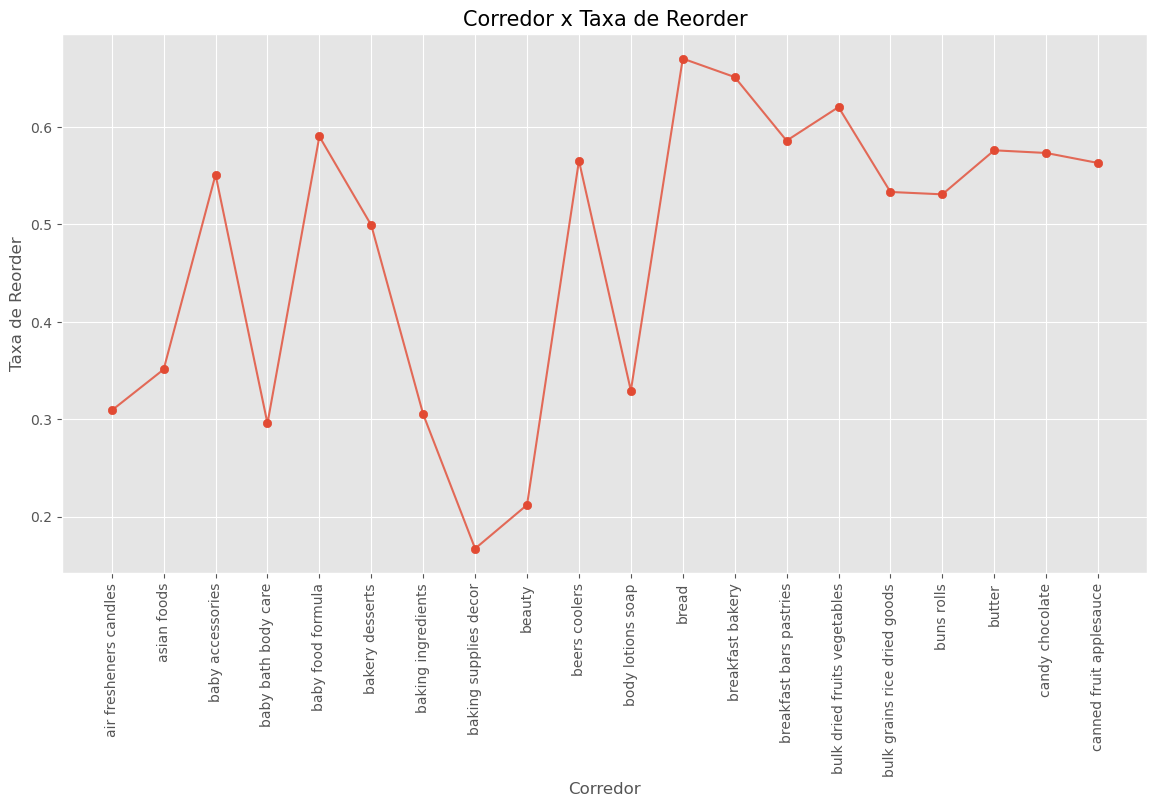

In [56]:
plt.figure(figsize=(14,7))
plt.plot(list(temp_df['aisle'])[0:20], temp_df['reordered'].values[0:20], alpha=0.8)
plt.scatter(list(temp_df['aisle'])[0:20], temp_df['reordered'].values[0:20])
plt.ylabel('Taxa de Reorder', fontsize=12)
plt.xlabel('Corredor', fontsize=12)
plt.title("Corredor x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

### 11 - Total de Pedidos e Reorder por Corredor

In [57]:
temp_df = order_product_prior.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

In [58]:
# Listas
labels = list(temp_df.aisle[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

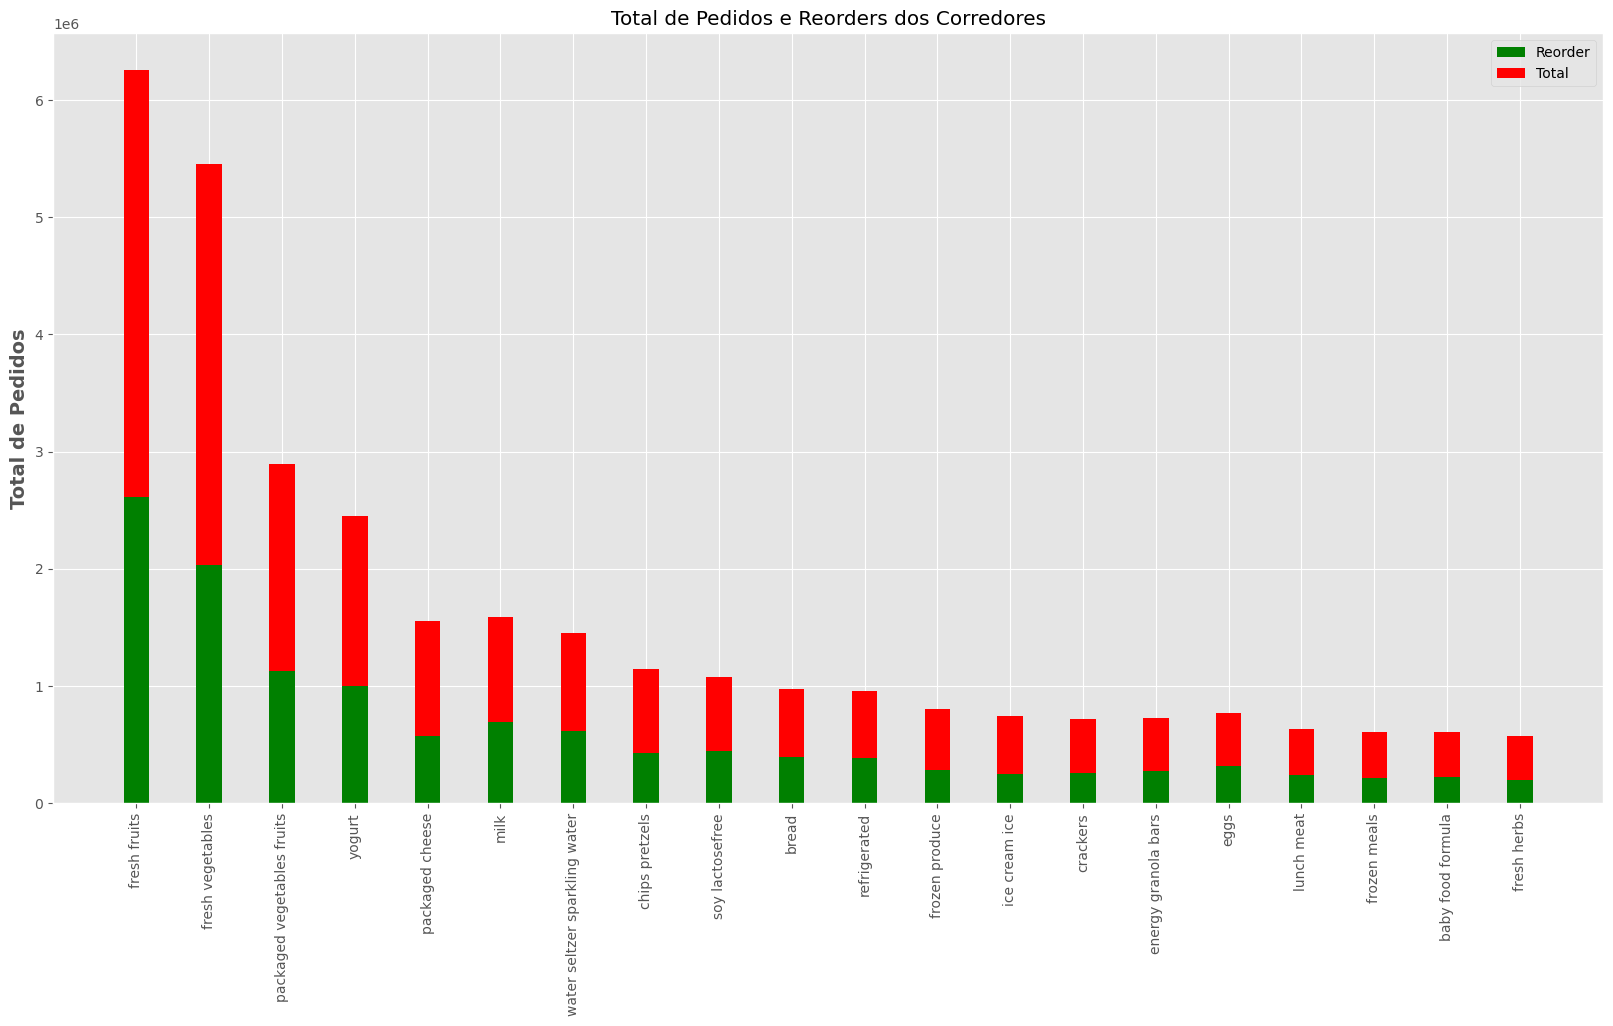

In [59]:
width = 0.35      
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Corredores")
plt.xticks(rotation = 90)
plt.show()